# JSL49_01 (CF-900)

In [172]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [40]:
## Preparing some stuff
# Libraries
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib, json, codecs, scipy, scipy.constants
import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
from IPython.core.display import display, HTML
import mjsplot as mplt
import dateutil
import scipy.special
digamma = scipy.special.digamma

# Display
# display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

# Physical constants
e = scipy.constants.e
k_B = scipy.constants.Boltzmann
h = scipy.constants.h
hbar = scipy.constants.hbar
Rk = h/e**2
Phi_0 = h/e # Flux quantum

# Load data
d = {}
df = {}
def loadin(filename): # a way to load in many different files and keep track of them. 
    datafile = json.loads( codecs.open('../data/'+filename,'r','utf-8').read() )
    key = datafile['attr']['_file counter']
    d[key]= datafile
    df[key] = pd.DataFrame(datafile['data']) 

# Data analysis

In [2]:
loadin('20180704T113230610Z-0084.json')
tdf = [df['0084'][df['0084']['Lockin 1 amplitude / V'] == amp] for amp in np.linspace(0.1,0.7,3)]

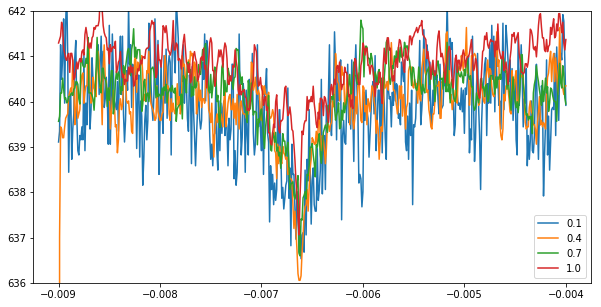

In [4]:
fig_1, ax_1 = plt.subplots(figsize=(10,5))
for tmpdf in tdf:
    B = tmpdf['Magnet Z / T']
    Vxx = tmpdf['AC Voltage xx / V']/(tmpdf['Lockin 1 amplitude / V'].values[0]/100*1e-6)
    ax_1.plot(B,Vxx,label=str(tmpdf['Lockin 1 amplitude / V'].values[0]))

loadin('20180704T081141439Z-0082.json')
B = df['0082']['Magnet Z / T']
Vxx = df['0082']['AC Voltage xx / V']/10e-9
ax_1.plot(B,Vxx,label='1.0')
# ax_1.set_xlim([-7e-3,-6e-3])
ax_1.set_ylim([636,642])
plt.legend()

In [5]:
for tmpdf in [tdf[1]]:
    B = tmpdf['Magnet Z / T']
    Vxx = tmpdf['AC Voltage xx / V']/(tmpdf['Lockin 1 amplitude / V'].values[0]/100*1e-6)
    ax_1.plot(B,Vxx,label=str(tmpdf['Lockin 1 amplitude / V'].values[0]))


# Fitting

## Model

In [5]:
# Model
def WAL_model(B,Bphi,Bso,Be):
    a = e**2/(2*np.pi**2*hbar)
    b = (Bso+Be)/B
    c = (4/3*Bso + Bphi)/B
    return a*(np.log(Bphi/B) - digamma(.5+Bphi/B))\
    + 2*a*(np.log(b) - digamma(.5+b))\
    - 3*a*(np.log(c) - digamma(.5+c))
# Data
def WAL_data(b,B,Vxx,Ibias):
    G = Ibias/Vxx
    return scipy.interp(b,B,G-np.max(G.values))

l_phi = 3.80e-07 m, l_SO = 3.80e-07 m, l_e = 3.80e-07 m.
l_phi = 1.07e-06 m, l_SO = 1.07e-06 m, l_e = 1.07e-06 m.


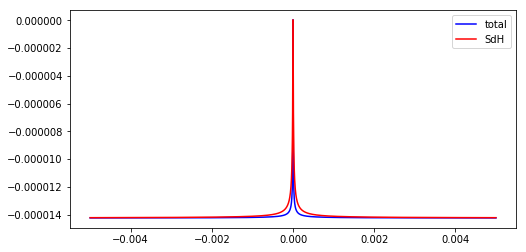

In [6]:
# Params
n = [3.4868766066386916e+16, 4880469527036150.5]
mu = [1.2323580034423407, 9.248209116291958]
le = [mu*h*np.sqrt(n) / (np.sqrt(2*np.pi) * e) for n,mu in zip(n,mu)]
Be = np.array([hbar/(4*e*i**2) for i in le])
Bphi = np.array([i for i in 1*Be])
Bso = np.array([i for i in 1*Be])
l = [1/np.sqrt(4*e*i/hbar) for i in [Bphi,Bso,Be]]

B = np.linspace(1e-9,5e-3,1001)

fig, ax = plt.subplots(figsize=(8,4))
for ii,clr,lbl in zip([0,1],['b','r'],['total','SdH']):
    print('l_phi = {0:.2e} m, l_SO = {1:.2e} m, l_e = {2:.2e} m.'.format(*(i[ii] for i in l)))
    cond = WAL_model(B,*[i[ii] for i in l])
    # Plot
    ax.plot(B,cond,color=clr,label=lbl)
    ax.plot(-B[::-1],cond[::-1],color=clr)
ax.legend(loc="upper right")

## Data

In [8]:
loadin('20180702T113329722Z-0058.json')
tdf = df['0058'][df['0058']['Magnet Z / T'] >= -7.4e-3]
B = np.linspace(1e-9,3e-3,51)
G = WAL_data(B,tdf['Magnet Z / T']+7.4e-3,tdf['AC Voltage xx / V'],100e-9)

#### All parameters run free

/Users/danielbouman/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


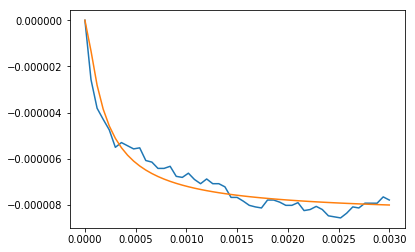

l_phi = 2.63 +- 3.80 um
l_SO = 3.06 +- 0.04 um
l_e = 2.36 +- 0.04 um.


In [245]:
popt,pcov = scipy.optimize.curve_fit(WAL_model,B,G)
plt.plot(B,G)
plt.plot(B,WAL_model(B,*popt))
plt.show()
print('l_phi = {0:.2f} +- {3:.2f} um\nl_SO = {1:.2f} +- {4:.2f} um\nl_e = {2:.2f} +- {5:.2f} um.'
      .format(*np.array([1/np.sqrt(4*e*B/hbar) for B in popt])*1e6,*[1/np.sqrt(4*e*B/hbar)*1e6 for B in np.sqrt(np.diag(pcov))]))
# print('l_phi error = {0:.2f} um, l_SO error = {1:.2f} um, l_e error = {2:.2f} um.'.format())

#### Bound l_e between 300 nm and 2 um

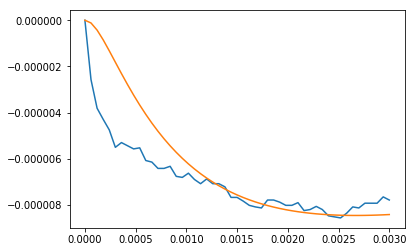

l_phi = 1.18 um, l_SO = 0.58 um, l_e = 0.30 um.
[2.9611132106539685e-06, 7.871218731410181e-07, 1.8375202086239903e-07]


In [76]:
p0 = [hbar/(4*e*l**2) for l in [1e-6,200e-9,400e-9]]
upbound = [hbar/(4*e*l**2) for l in [1e-9,1e-9,300e-9]] # lower bounds for l
lowbound = [hbar/(4*e*l**2) for l in [100e-6,10e-6,2e-6]] # upper bounds for l
popt,pcov = scipy.optimize.curve_fit(WAL_model,B,G,p0=p0,bounds=(lowbound,upbound))
plt.plot(B,G)
plt.plot(B,WAL_model(B,*popt))
plt.show()
print('l_phi = {0:.2f} um, l_SO = {1:.2f} um, l_e = {2:.2f} um.'.format(*np.array([1/np.sqrt(4*e*B/hbar) for B in popt])*1e6))
print([1/np.sqrt(4*e*B/hbar) for B in np.sqrt(np.diag(pcov))])

#### Attila messing things up

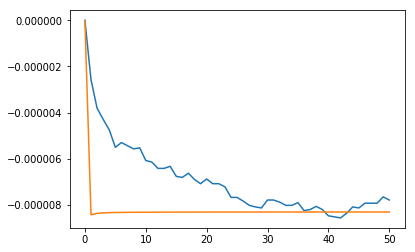

In [13]:
B = np.linspace(1e-9,3e-3,51)
l_phi = 200e-6
l_SO = 66e-6
l_e = 39.81e-6
params = [hbar/(4*e*l**2) for l in [l_phi,l_SO,l_e]]
plt.plot(WAL_data(B,tdf['Magnet Z / T']+7.4e-3,tdf['AC Voltage xx / V'],100e-9))
plt.plot(WAL_model(B,*params))

### Gate dependent data

In [41]:
loadin('20180704T184040960Z-0087.json')

l_phi = 4.79 um, l_SO = 3.27 um, l_e = 2.41 um.
[10.677621785516898, 6.313746890027187, 4.373059839177003]


/Users/danielbouman/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


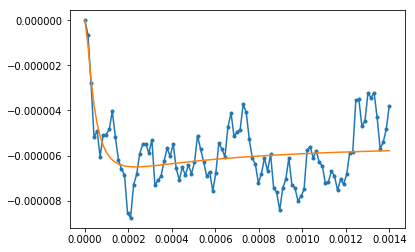

In [42]:
B = np.linspace(1e-9,1.4e-3,101)
tdf = df['0087'][df['0087']['Gate dac 2 / mV'] == -500]
offset = tdf['Magnet Z / T'][tdf['AC Voltage xx / V'].idxmin()]
G = WAL_data(B,tdf['Magnet Z / T']-offset,tdf['AC Voltage xx / V'],4e-9)
ini = [hbar/(4*e*l**2) for l in [1e-6,1e-6,1e-6]]
popt,pcov = scipy.optimize.curve_fit(WAL_model,B,G,p0=ini)
plt.plot(B,G,'.-')
plt.plot(B,WAL_model(B,*popt))
print('l_phi = {0:.2f} um, l_SO = {1:.2f} um, l_e = {2:.2f} um.'.format(*[1e6/np.sqrt(4*e*B/hbar) for B in popt]))
print([1e6/np.sqrt(4*e*B/hbar) for B in np.sqrt(np.diag(pcov))])

/Users/danielbouman/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


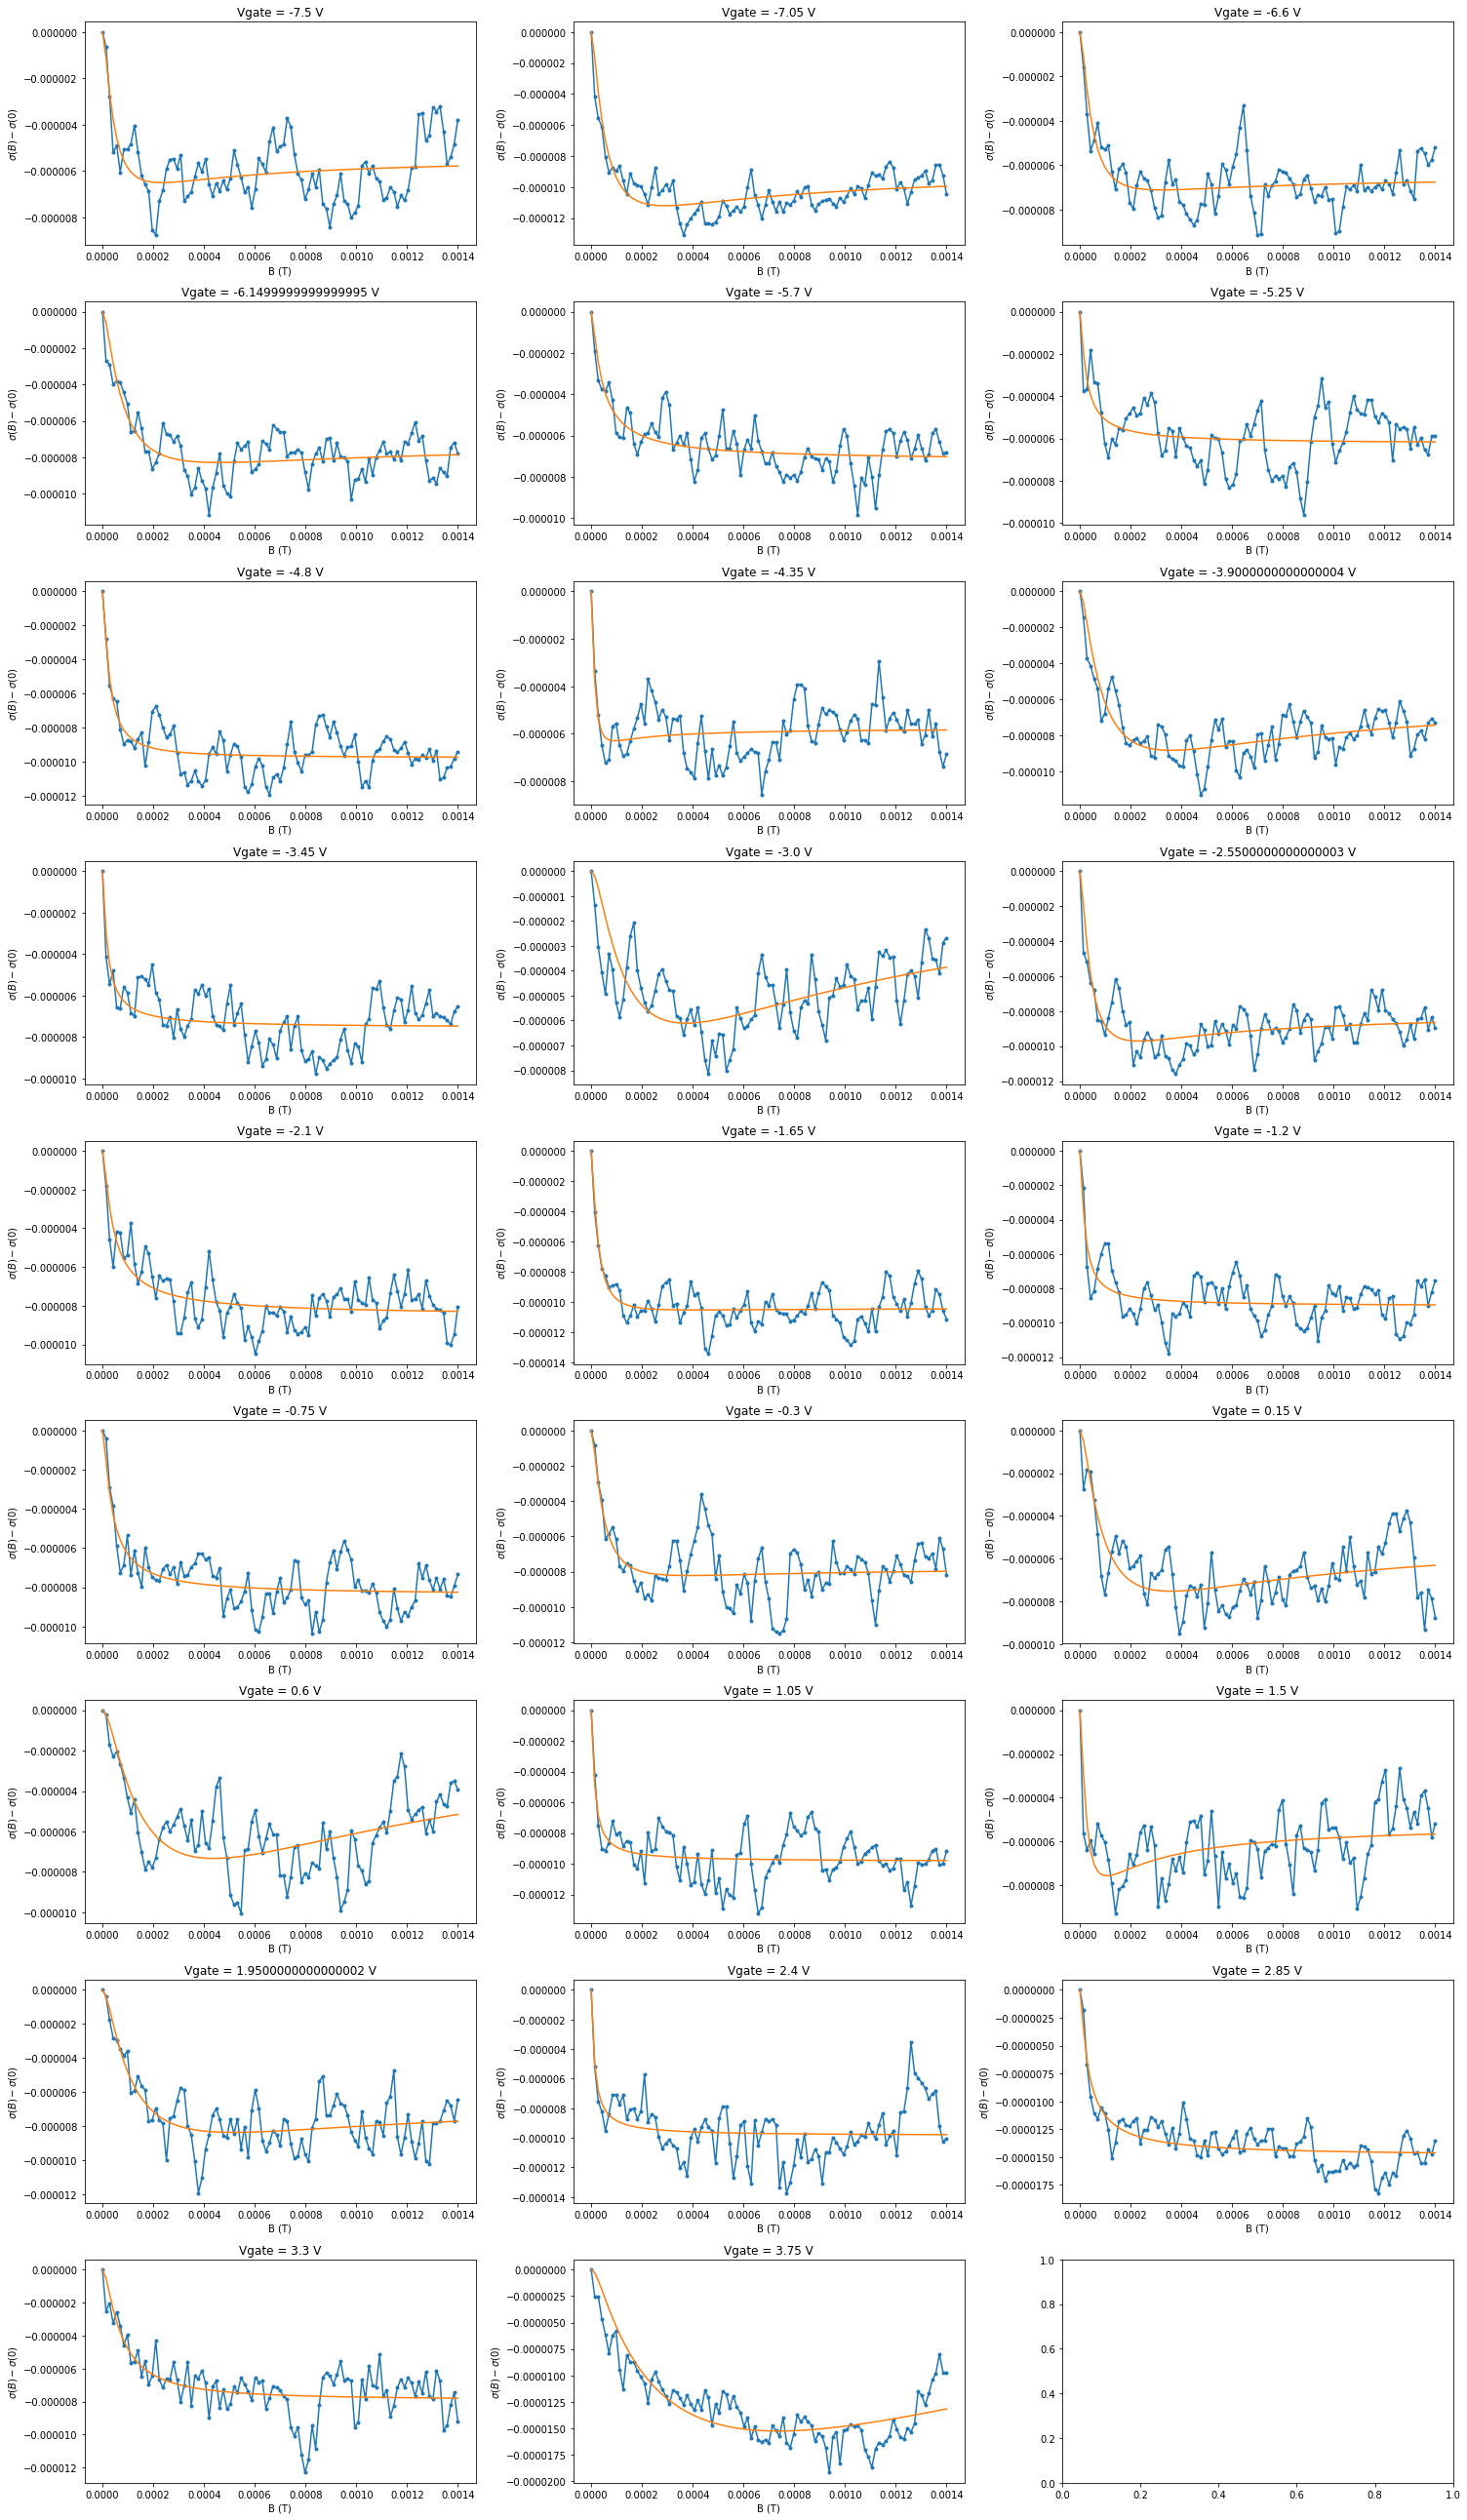

In [10]:
loadin('20180704T184040960Z-0087.json')
subfigs = np.ceil(df['0087']['Gate dac 2 / mV'].unique().size)
if subfigs <= 3:
    rows,cols = 1,int(subfigs)
else:
    rows,cols = int(np.ceil(subfigs/3)),3
fig_wal,ax_wal = plt.subplots(nrows=rows,ncols=cols,figsize=(cols*7,rows*4))
ax_wal = sum(ax_wal.tolist(), [])
l_fits = {}
l_fits_error = {}
l_vgate = []
for i,(label,group) in enumerate(df['0087'].groupby('Gate dac 2 / mV')):
    B = np.linspace(1e-9,1.4e-3,101)
    offset = group['Magnet Z / T'][group['AC Voltage xx / V'].idxmin()]
    G = WAL_data(B,group['Magnet Z / T']-offset,group['AC Voltage xx / V'],4e-9)
    p0 = [hbar/(4*e*l**2) for l in [1e-6,1e-6,1e-6]]
    popt,pcov = scipy.optimize.curve_fit(WAL_model,B,G,p0=p0)
    ax_wal[i].plot(B,G,'.-')
    ax_wal[i].plot(B,WAL_model(B,*popt))
    ax_wal[i].set_title('Vgate = {} V'.format(label/1e3*15))
    ax_wal[i].set_xlabel('B (T)')
    ax_wal[i].set_ylabel(u'$\sigma(B) - \sigma(0)$')
    l_vgate.append(label/1e3*15)
    l_all = [1/np.sqrt(4*e*B/hbar) for B in popt]
    l_errors = [1/np.sqrt(4*e*B/hbar)/2 for B in np.sqrt(np.diag(pcov))]
    for dic,vals in zip([l_fits,l_fits_error],[l_all,l_errors]):
        for key,l in zip(['l_phi','l_SO','l_e'],vals):
            if key in dic:
                dic[key].append(l)
            else:
                dic[key] = [l]

#     print('l_phi = {0:.2f} um, l_SO = {1:.2f} um, l_e = {2:.2f} um.'
#           .format(*np.array([1/np.sqrt(4*e*B/hbar) for B in popt])*1e6))
#     print([1/np.sqrt(4*e*B/hbar) for B in np.sqrt(np.diag(pcov))])
fig_wal.tight_layout()

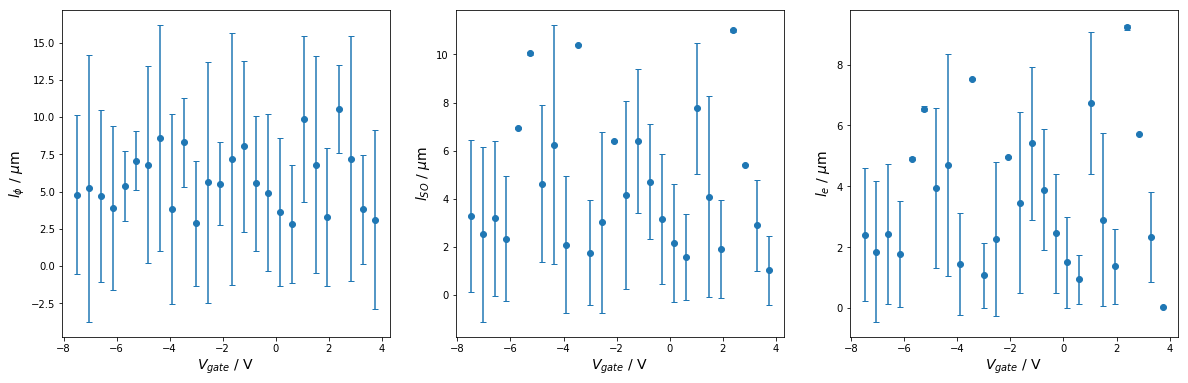

Mean values:
l_phi = 5.75 +- 5.37 um
l_SO = 4.58 +- 2.25 um
l_e = 3.53 +- 1.54 um


In [33]:
fig, axes = plt.subplots(figsize=(20,6),ncols=3)
ylabels = [u'$l_\phi$ / $\mu$m',u'$l_{SO}$ / $\mu$m',u'$l_{e}$ / $\mu$m']

for ax,(_,ls),(__,ls_error),ylabel in zip(axes,l_fits.items(),l_fits_error.items(),ylabels):
    ax.errorbar(l_vgate,np.array(ls)*1e6,yerr=np.array(ls_error)*1e6,fmt='o',capsize=3)
    ax.set_xlabel(u'$V_{gate}$ / V', fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
plt.show()

l_mean = [np.mean(l)*1e6 for _,l in l_fits.items()]
l_mean_error = [np.mean(l)*1e6 for _,l in l_fits_error.items()]
print('Mean values:\nl_phi = {0:.2f} +- {3:.2f} um\nl_SO = {1:.2f} +- {4:.2f} um\nl_e = {2:.2f} +- {5:.2f} um'.format(*l_mean+l_mean_error))

In [35]:
a = list(map(lambda x: json.loads(x) if len(x)>0 else {},codecs.open('../data/20180706T154850269Z-0103.json.jsonl').read().split('\n')))
df = pd.DataFrame(a)